## Calculate water transports and save in files


This notebook calculates the water transport through several cross sections along the shelf, across the shelf and vertically, from canyon to shelf. See plot below. Transport is calculated as $u_i * a_i$, with units m3/s and each transport xarray dataset is stored in a file according to its orientation:

* run##water_CS_transports.nc - cross-shelf and vertical transports

There is one of each files for every run.

In [1]:
from math import *
from matplotlib.dates import num2date
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import xarray as xr

In [2]:
# Define slices and positions of cross sections 
CS1_x_slice = slice(0, 59)
CS2_x_slice = slice(60, 119)
CS3_x_slice = slice(120, 239)
CS4_x_slice = slice(240, 299)
CS5_x_slice = slice(300, 359)
CSCOAST_x_slice = slice(0, 359)

CS_y_coast = 358
CS1_y_ind = 227

AS1_y_slice = slice(227, 266)
AS2_y_slice = slice(267, 298)
AS3_y_slice = slice(299, 359)

AS1_x_ind = 119
AS1b_x_ind = 239

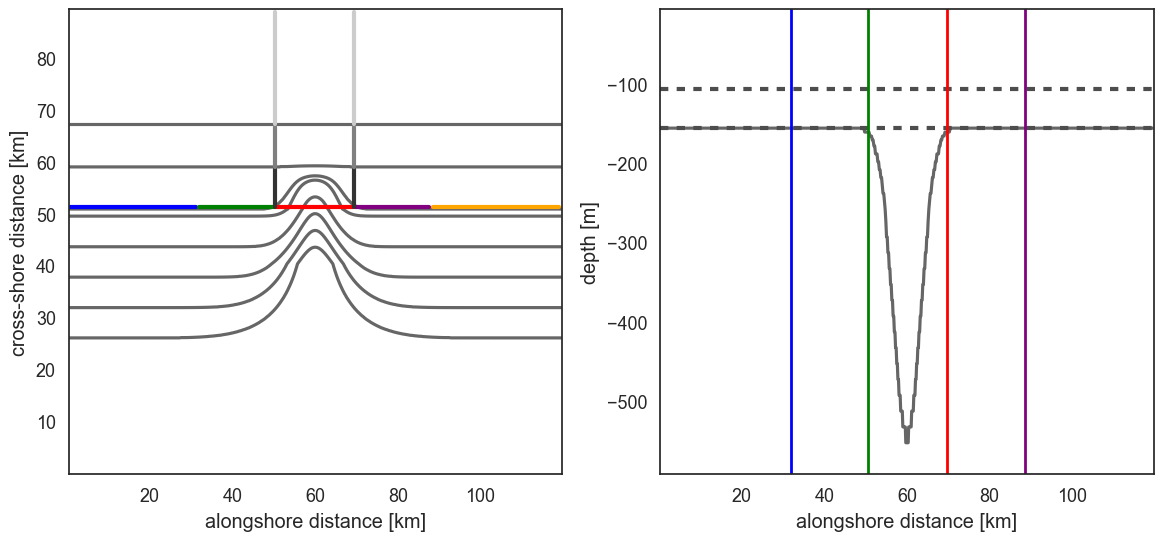

In [3]:
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

sns.set_style(style='white')
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].contour(grid.X/1000,grid.Y/1000,grid.Depth,[50,100,150,200,400,600,800,1000], colors='0.4')

ax[0].plot(grid.XC[CS1_y_ind,CS1_x_slice]/1000,grid.YC[CS1_y_ind,CS1_x_slice]/1000, 'b-', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS2_x_slice]/1000,grid.YC[CS1_y_ind,CS2_x_slice]/1000, 'g-', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS3_x_slice]/1000,grid.YC[CS1_y_ind,CS3_x_slice]/1000, 'r-', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS4_x_slice]/1000,grid.YC[CS1_y_ind,CS4_x_slice]/1000, '-',color='purple', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS5_x_slice]/1000,grid.YC[CS1_y_ind,CS5_x_slice]/1000, '-', color='orange', linewidth=3)

ax[0].plot(grid.XC[AS1_y_slice,AS1_x_ind]/1000,grid.YC[AS1_y_slice,AS1_x_ind]/1000, '-', color='0.2',linewidth=3)
ax[0].plot(grid.XC[AS2_y_slice,AS1_x_ind]/1000,grid.YC[AS2_y_slice,AS1_x_ind]/1000, '-', color='0.5',linewidth=3)
ax[0].plot(grid.XC[AS3_y_slice,AS1_x_ind]/1000,grid.YC[AS3_y_slice,AS1_x_ind]/1000, '-', color='0.8',linewidth=3)

ax[0].plot(grid.XC[AS1_y_slice,AS1b_x_ind]/1000,grid.YC[AS1_y_slice,AS1b_x_ind]/1000, '-', color='0.2', linewidth=3)
ax[0].plot(grid.XC[AS2_y_slice,AS1b_x_ind]/1000,grid.YC[AS2_y_slice,AS1b_x_ind]/1000, '-', color='0.5', linewidth=3)
ax[0].plot(grid.XC[AS3_y_slice,AS1b_x_ind]/1000,grid.YC[AS3_y_slice,AS1b_x_ind]/1000, '-', color='0.8', linewidth=3)

ax[0].set_xlabel('alongshore distance [km]')
ax[0].set_ylabel('cross-shore distance [km]')

ax[1].contour(grid.XC[227,:]/1000,grid.RC[:60],grid.HFacC[:60,227,:],[0],colors='0.4')
ax[1].plot([grid.X[0]/1000,grid.X[359]/1000],[grid.RC[20],grid.RC[20]], '--', color='0.3', linewidth=3)
ax[1].plot([grid.X[0]/1000,grid.X[359]/1000],[grid.RC[30],grid.RC[30]], '--', color='0.3', linewidth=3)

ax[1].axvline(x=grid.X[60]/1000,color='b', linewidth=2)
ax[1].axvline(x=grid.X[120]/1000,color='g', linewidth=2)
ax[1].axvline(x=grid.X[240]/1000,color='r', linewidth=2)
ax[1].axvline(x=grid.X[300]/1000,color='purple', linewidth=2)


ax[1].set_xlabel('alongshore distance [km]')
ax[1].set_ylabel('depth [m]')


In [4]:
def calc_wat_transport_CS(vel_component, x_slice, y_slice, spacing, zspacing, dim_name,zini=0,zfin=30):
    '''
    INPUT:
    vel_component: xarray, Velocity component perpendicular to cross section (e.g. unstagger_xarray(state03.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    spacing: xarray, width of cross section elements (e.g. dxG, etc)
    dim_name: str, name of the dimension along which to sum.
    
    '''
    vel_CS = (vel_component.isel(Yp1=y_slice, X=x_slice))
    dx_CS = (spacing.isel(Yp1=y_slice, X=x_slice))

    waterCS_flux = (((dx_CS*vel_CS).sum(dim=dim_name))*zspacing).isel(Z=slice(zini,zfin)).sum(dim='Z')

    return waterCS_flux


def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty
    

In [5]:
#set up paths and files
grid_Can_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid_NoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'


In [6]:
import os
import sys
lib_path = os.path.abspath('../PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

In [7]:
records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [8]:
# Save water transport canyon runs

grid = xr.open_dataset(grid_Can_file)

ii = 0

for rec in records[11:15]:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/stateGlob.nc' %(rec.exp_code,rec.run_num))
    state = xr.open_dataset(filename)
    
    
    waterCS1_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS1_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF, 'X')
    waterCS2_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS2_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , 'X')
    waterCS3_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS3_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , 'X')
    waterCS3b_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS3_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , 'X',zini=30,zfin=90)
    
    waterCS4_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS4_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , 'X')
    waterCS5_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS5_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , 'X')
    #waterCS_COAST_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CSCOAST_x_slice, CS_y_coast,
    #                                      unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , 'X')
    
    vel_vert = (unstagger_xarray(state.W,'Zl').isel(Zl=29,Y=slice(227,267), X=slice(120,240)))
    area = (grid.rA.isel(Y=slice(227,267), X=slice(120,240)))

    waterVert_flux = (vel_vert*area).sum(dim='Y').sum(dim='X')
    waterVert_flux.name = 'Vert_water_trans_sb'
    waterVert_flux.attrs['units'] = 'm3/s'

    waterCS1_flux.name = 'CS1_water_trans'
    waterCS1_flux.attrs['units'] = 'm3/s'
    waterCS2_flux.name = 'CS2_water_trans'
    waterCS2_flux.attrs['units'] = 'm3/s'
    waterCS3_flux.name = 'CS3_water_trans'
    waterCS3_flux.attrs['units'] = 'm3/s'
    waterCS3b_flux.name = 'CS3b_water_trans'
    waterCS3_flux.attrs['units'] = 'm3/s'
    waterCS4_flux.name = 'CS4_water_trans'
    waterCS4_flux.attrs['units'] = 'm3/s'
    waterCS5_flux.name = 'CS5_water_trans'
    waterCS5_flux.attrs['units'] = 'm3/s'
    #waterCS_COAST_flux.name = 'CS_COAST_water_trans'
    #waterCS_COAST_flux.attrs['units'] = 'm3/s'
   
    objectsCS = [waterCS1_flux, waterCS2_flux,waterCS3_flux,waterCS3b_flux,waterCS4_flux,
                 waterCS5_flux,waterVert_flux]
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    
    DS_CS_path = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(rec.exp_code,rec.run_num))+
                  'water_CS_transports.nc')
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', format='NETCDF4')
    
    print(DS_CS_path)
    ii=ii+1
    


/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run01water_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run02water_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run03water_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/run04water_CS_transports.nc


In [9]:
# Save water transport for no canyon runs

grid = xr.open_dataset(grid_Can_file)

ii = 0

for rec in recordsNoC:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/stateGlob.nc' %(rec.exp_code,rec.run_num))
    state = xr.open_dataset(filename)
    
    
    waterCS1_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS1_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF, 'X')
    waterCS2_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS2_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , 'X')
    waterCS3_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS3_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , 'X')
    waterCS3b_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS3_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , 'X',zini=30,zfin=90)
    
    waterCS4_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS4_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , 'X')
    waterCS5_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CS5_x_slice, CS1_y_ind,
                                          unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , 'X')
    #waterCS_COAST_flux = calc_wat_transport_CS(unstagger_xarray(state.V,'Yp1'), CSCOAST_x_slice, CS_y_coast,
    #                                       unstagger_xarray(grid.dxG, 'Yp1'), grid.drF , 'X')
    
    vel_vert = (unstagger_xarray(state.W,'Zl').isel(Zl=29,Y=slice(227,267), X=slice(120,240)))
    area = (grid.rA.isel(Y=slice(227,267), X=slice(120,240)))

    waterVert_flux = (vel_vert*area).sum(dim='Y').sum(dim='X')
    waterVert_flux.name = 'Vert_water_trans_sb'
    waterVert_flux.attrs['units'] = 'm3/s'

    waterCS1_flux.name = 'CS1_water_trans'
    waterCS1_flux.attrs['units'] = 'm3/s'
    waterCS2_flux.name = 'CS2_water_trans'
    waterCS2_flux.attrs['units'] = 'm3/s'
    waterCS3_flux.name = 'CS3_water_trans'
    waterCS3_flux.attrs['units'] = 'm3/s'
    waterCS3b_flux.name = 'CS3b_water_trans'
    waterCS3_flux.attrs['units'] = 'm3/s'
    waterCS4_flux.name = 'CS4_water_trans'
    waterCS4_flux.attrs['units'] = 'm3/s'
    waterCS5_flux.name = 'CS5_water_trans'
    waterCS5_flux.attrs['units'] = 'm3/s'
    #waterCS_COAST_flux.name = 'CS_COAST_water_trans'
    #waterCS_COAST_flux.attrs['units'] = 'm3/s'
   
    objectsCS = [waterCS1_flux, waterCS2_flux,waterCS3_flux,waterCS3b_flux,waterCS4_flux,
                 waterCS5_flux,waterVert_flux]
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(rec.exp_code,rec.run_num))+
                  'water_CS_transports.nc')
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', format='NETCDF4')
    
   
    print(DS_CS_path)
    ii=ii+1
    


/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run50water_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42water_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run41water_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run40water_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run48water_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run74water_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run76water_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run68water_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run53water_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run70water_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run72water_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42water_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42water_CS_transports.nc